In [ ]:
dsxfrom PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pandas as pd

In [ ]:
path_to_data = '/scratch/liy31/myjupyter/capstone/CD27/121919_Myo089_[9866,52200]_component_data.tif'

def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)

img = read_tiff(path_to_data)

/home/liy31/.local/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: [Errno 22] Invalid argument
  warnings.warn(str(msg))
<ipython-input-4-d850464e9bff>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images)


In [ ]:
import numpy as np
from PIL import Image
from torchvision import transforms
import torch

brightness = (1, 10)
contrast = (1, 10)
saturation = (1, 10)
hue = (0.2, 0.4)
size = (224,224)
degrees = (15, 30)

input_image = Image.open(path_to_data)
#m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.ColorJitter(brightness, contrast, saturation, hue),
    #transforms.CenterCrop(50),
    #transforms.FiveCrop(size),
    transforms.RandomRotation(degrees),
    #transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),

])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)



NameError: ignored

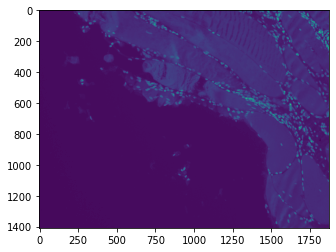

In [ ]:
plt.imshow(img[0])

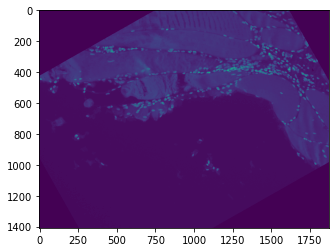

In [ ]:
plt.imshow(input_tensor.squeeze())

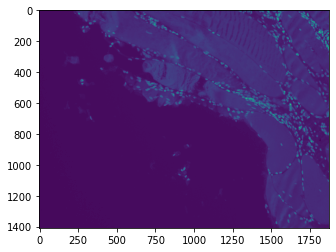

In [ ]:
plt.imshow(img[0])

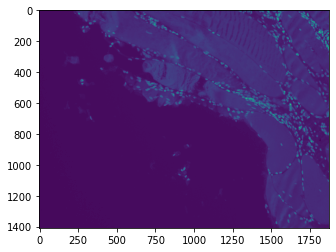

In [ ]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),

])
input_tensor = preprocess(img[0])
plt.imshow(input_tensor.squeeze())

In [ ]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

print(torch.round(output[0]))

NameError: name 'input_tensor' is not defined

In [ ]:
def window_nd(a, window, steps = None):
    ashp = a.shape
    pad = np.zeros((len(window),2))
    for _ in range(pad.shape[0]):
        pad[_,1] = window[_] - (steps[_] * (window[_] // steps[_]) + ashp[_] % steps[_])
        while pad[_,1] < 0:
            pad[_,1] += steps[_]
    pad = pad.astype(int)
    a = np.pad(a, pad)
    ashp = np.array(a.shape)
    wshp = np.array(window).reshape(-1)
    if steps:
        stp = np.array(steps).reshape(-1)
    else:
        stp = np.ones_like(ashp)
    astr = np.array(a.strides)
    assert np.all(np.r_[ashp.size == wshp.size, wshp.size == stp.size, wshp <= ashp])
    shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
    strides = tuple(astr * stp) + tuple(astr)
    as_strided = np.lib.stride_tricks.as_strided
    aview = as_strided(a, shape = shape, strides = strides)
    return aview

In [ ]:
aview = window_nd(img[0], (256, 256), (26,26))
print(aview.shape)
aview = aview.reshape(-1, 256, 256)

(46, 64, 256, 256)


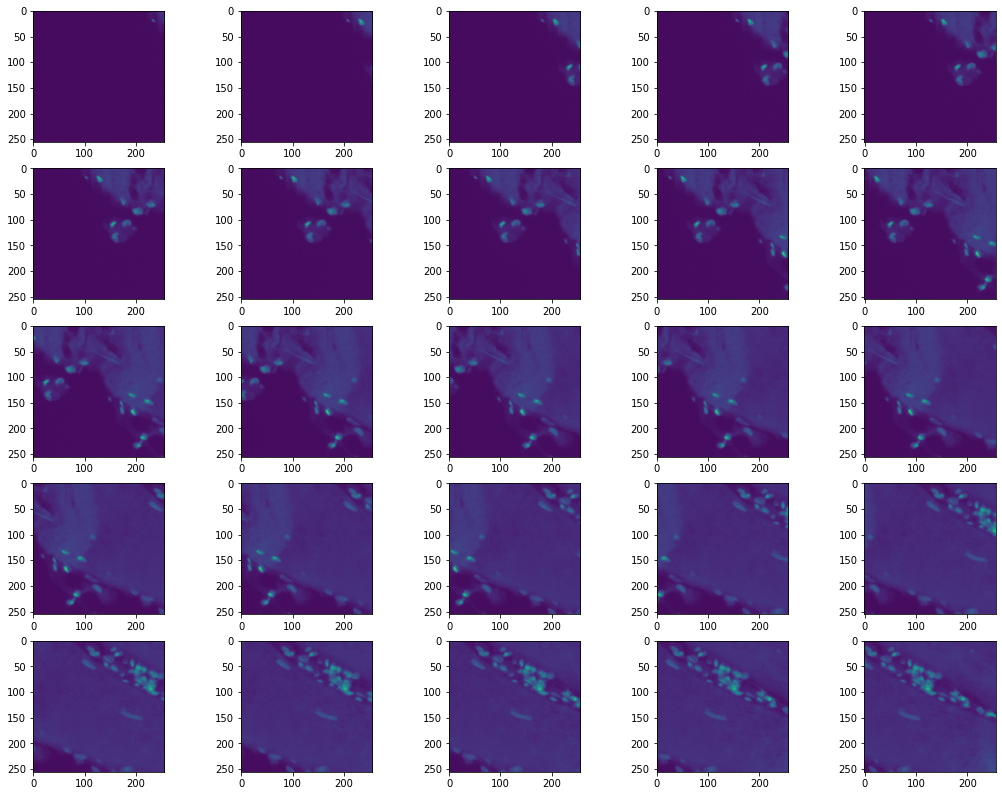

In [ ]:
fig = plt.figure(figsize=(18,14))
for _ in range(25):
    plt.subplot(5,5,_+1)
    plt.imshow(aview[_], vmin=img[0].min(), vmax=img[0].max())
plt.show()

In [ ]:
data_file = os.listdir('/scratch/liy31/myjupyter/capstone/CD27')
label_file = os.listdir('/scratch/liy31/myjupyter/capstone/CD27_labels')
label_file.remove('Bounding Rectangle')

In [ ]:
selected_data = set([_[:-9] for _ in data_file]).intersection(set([_[:-11] for _ in label_file]))
print(len(selected_data))

198


In [ ]:
for _ in tqdm(selected_data):
    path_to_data = '/scratch/liy31/myjupyter/capstone/CD27/' + _ + '_data.tif'
    img = read_tiff(path_to_data)
    aview = window_nd(img[0], (256, 256), (26,26))
    aview = aview.reshape(-1, 256, 256)
    for idx in range(aview.shape[0]):
        np.save('/scratch/liy31/myjupyter/capstone/train_data_overlap/' + _ + '_data_' + str(idx), aview[idx])
    path_to_target = '/scratch/liy31/myjupyter/capstone/CD27_labels/' + _ + '_datalabels'
    label = pd.read_table(path_to_target, usecols=[1,2,3])
    target = np.zeros(img[0].shape)
    for x, y in zip(label.X, label.Y):
        try:
            target[int(y)-1, int(x)-1] = 1
        except:
            continue
    aview = window_nd(target, (256, 256), (26,26))
    aview = aview.reshape(-1, 256, 256)
    for idx in range(aview.shape[0]):
        np.save('/scratch/liy31/myjupyter/capstone/train_label_overlap/' + _ + '_target_' + str(idx), aview[idx])

  0%|          | 0/198 [00:00<?, ?it/s]<ipython-input-2-d850464e9bff>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images)
100%|██████████| 198/198 [48:14<00:00, 14.62s/it]
